Connected to gift (Python 3.13.0)

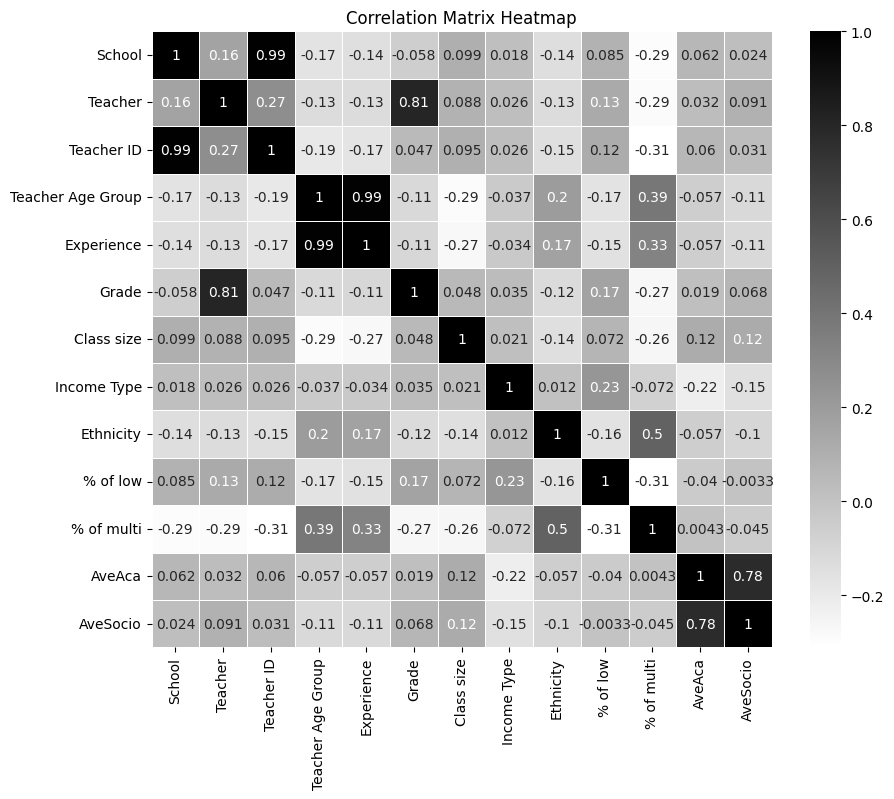

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV file
# file_path = './HOPE-Data-Kor-Master-data-only-students.csv'
file_path = './HOPE-Data-Kor-Master-data.csv'

data = pd.read_csv(file_path)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix using a heatmap
# %%
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='binary', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Display correlation matrix as a table
#import ace_tools as tools
#tools.display_dataframe_to_user(name="Correlation Matrix", dataframe=correlation_matrix)

In [ ]:
# Nomalize the AveAca and AveSocio (remove differences)
# Specify columns to normalize
columns_to_normalize = ['AveAca', 'AveSocio']

# Calculate and store the standard deviation before normalization
data['AveAca_StdDev_Before'] = data.groupby('Teacher ID')['AveAca'].transform('std')
data['AveSocio_StdDev_Before'] = data.groupby('Teacher ID')['AveSocio'].transform('std')

# Normalize the specified columns based on Teacher ID
data[columns_to_normalize] = data.groupby('Teacher ID')[columns_to_normalize].transform(lambda x: (x - x.mean()) / x.std())

# Calculate and store the standard deviation after normalization
data['AveAca_StdDev_After'] = data.groupby('Teacher ID')['AveAca'].transform('std')
data['AveSocio_StdDev_After'] = data.groupby('Teacher ID')['AveSocio'].transform('std')

# Save the normalized data with standard deviations to a CSV file
data.to_csv('normalized_data_with_stddev.csv', index=False)
print("Normalized data with standard deviations saved to 'normalized_data_with_stddev.csv'")

Normalized data with standard deviations saved to 'normalized_data_with_stddev.csv'


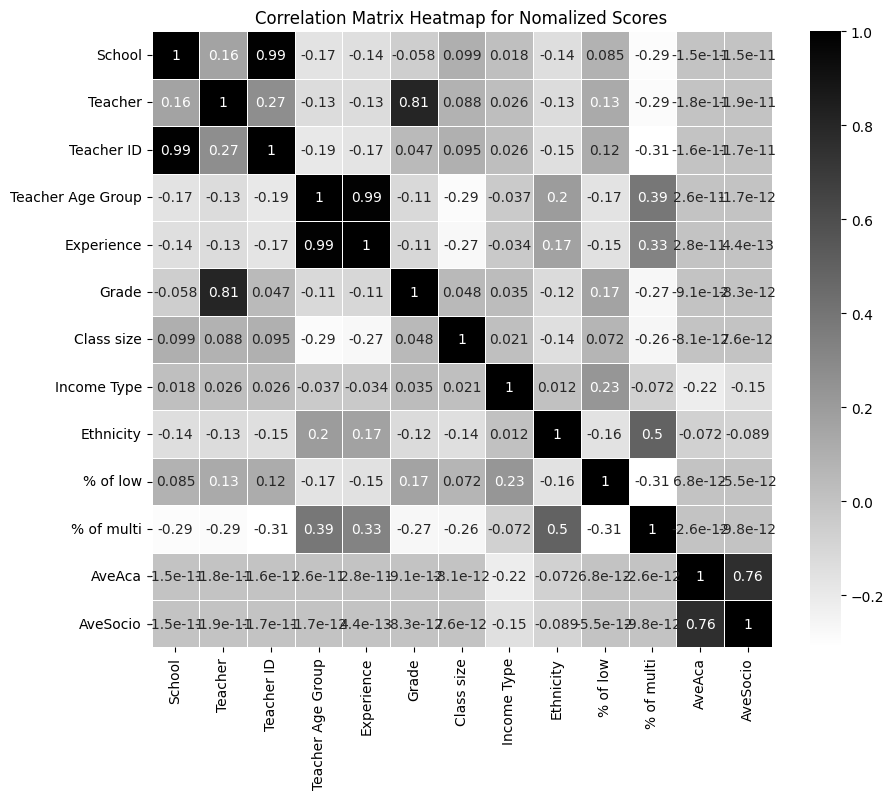

In [ ]:
file_path = './normalized_data_with_stddev_revised01.csv'

data2 = pd.read_csv(file_path)

# Calculate the correlation matrix
correlation_matrix = data2.corr()

# Plot the correlation matrix using a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='binary', linewidths=0.5)
plt.title('Correlation Matrix Heatmap for Nomalized Scores')
plt.show()

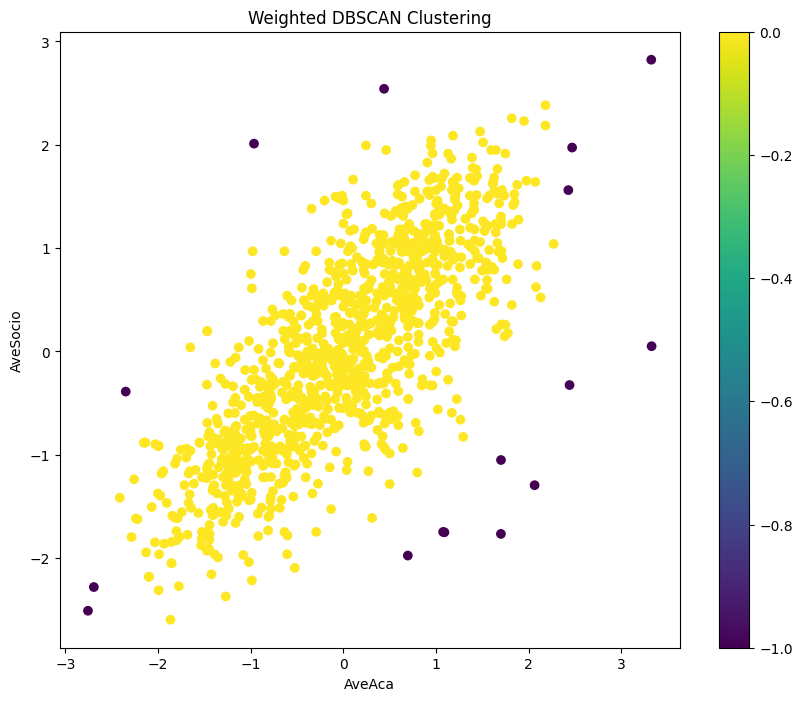

Weighted DBSCAN Cluster -1: 1.38%
Weighted DBSCAN Cluster 0: 98.62%



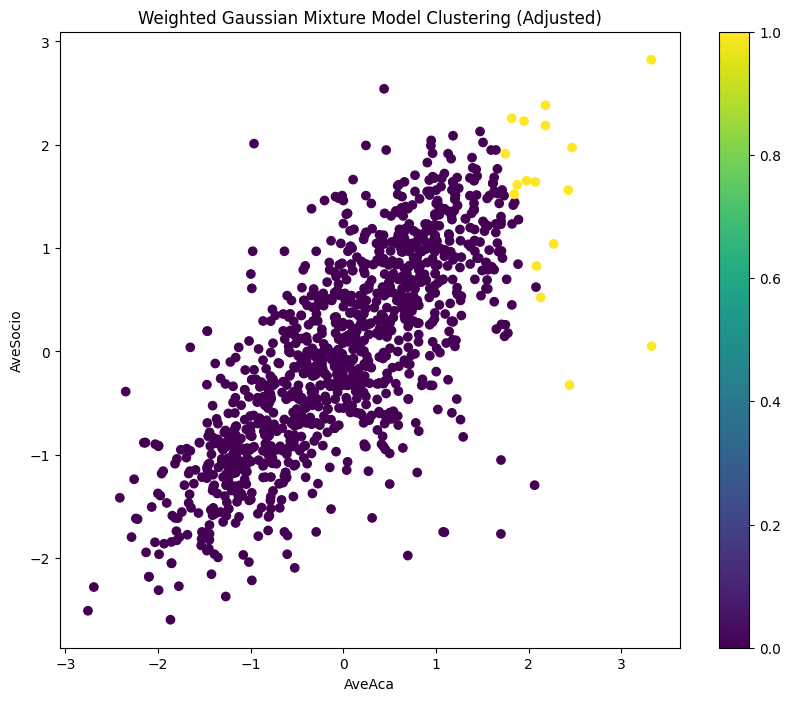

Weighted GMM (Adjusted) Cluster 0: 98.53%
Weighted GMM (Adjusted) Cluster 1: 1.47%


Weighted GMM Cluster Means:
Cluster 0: AveAca = -0.78, AveSocio = -0.70
Cluster 1: AveAca = 0.64, AveSocio = 0.58

Weighted GMM Cluster Covariances:
Cluster 0:
[[0.32108517 0.15425843]
 [0.15425843 0.15031781]]
Cluster 1:
[[0.33909025 0.11491414]
 [0.11491414 0.19169989]]

Weighted GMM Probability ranges for each cluster:
Cluster 0: Min = 0.0000, Max = 0.9999
Cluster 1: Min = 0.0001, Max = 1.0000

Weighted GMM Data point with highest combined score (potentially most gifted):
AveAca = 3.32, AveSocio = 2.82
GMM Probability for gifted cluster: 1.0000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# Load your data
df = pd.read_csv('./normalized_data_with_stddev_revised01.csv')
X = df[['AveAca', 'AveSocio']].values

# Define weights
weights = np.array([0.7, 0.3])

def weighted_euclidean(x, y):
    return np.sqrt(np.sum(weights * (x - y)**2))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_weighted = X_scaled * np.sqrt(weights)

def plot_clusters(X, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('AveAca')
    plt.ylabel('AveSocio')
    plt.show()

def print_cluster_percentages(labels, algorithm_name):
    unique, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique, counts):
        percentage = count / len(labels) * 100
        print(f"{algorithm_name} Cluster {label}: {percentage:.2f}%")
    print()

# Function to adjust labels to achieve 1.5% split based on both AveAca and AveSocio
def adjust_labels(X, probabilities, target_percentage=0.015):
    # Calculate a combined score (weighted sum of AveAca and AveSocio)
    combined_score = X[:, 0] * weights[0] + X[:, 1] * weights[1]
    sorted_indices = np.argsort(combined_score)[::-1]
    n_gifted = int(len(probabilities) * target_percentage)
    adjusted_labels = np.zeros(len(probabilities), dtype=int)
    adjusted_labels[sorted_indices[:n_gifted]] = 1
    return adjusted_labels

# Weighted DBSCAN
dbscan_w = DBSCAN(eps=0.3, min_samples=5, metric='precomputed')
distances = pairwise_distances(X_scaled, metric=weighted_euclidean)
dbscan_w_labels = dbscan_w.fit_predict(distances)
plot_clusters(X, dbscan_w_labels, 'Weighted DBSCAN Clustering')
print_cluster_percentages(dbscan_w_labels, "Weighted DBSCAN")

# Weighted GMM
gmm_w = GaussianMixture(n_components=2, random_state=42)
gmm_w.fit(X_scaled_weighted)
gmm_w_proba = gmm_w.predict_proba(X_scaled_weighted)
gmm_w_labels = adjust_labels(X_scaled_weighted, gmm_w_proba)
plot_clusters(X, gmm_w_labels, 'Weighted Gaussian Mixture Model Clustering (Adjusted)')
print_cluster_percentages(gmm_w_labels, "Weighted GMM (Adjusted)")

# Additional GMM analysis
print("\nWeighted GMM Cluster Means:")
cluster_means = scaler.inverse_transform(gmm_w.means_ / np.sqrt(weights))
for i, mean in enumerate(cluster_means):
    print(f"Cluster {i}: AveAca = {mean[0]:.2f}, AveSocio = {mean[1]:.2f}")

print("\nWeighted GMM Cluster Covariances:")
for i, cov in enumerate(gmm_w.covariances_):
    print(f"Cluster {i}:")
    print(cov)

print("\nWeighted GMM Probability ranges for each cluster:")
for i in range(2):
    cluster_probs = gmm_w_proba[:, i]
    print(f"Cluster {i}: Min = {cluster_probs.min():.4f}, Max = {cluster_probs.max():.4f}")

gifted_cluster = 1  # Assuming 1 is the gifted cluster
combined_score = X_scaled_weighted[:, 0] * weights[0] + X_scaled_weighted[:, 1] * weights[1]
highest_score_index = np.argmax(combined_score)
highest_score_point = X[highest_score_index]
highest_score_prob = gmm_w_proba[highest_score_index, gifted_cluster]

print(f"\nWeighted GMM Data point with highest combined score (potentially most gifted):")
print(f"AveAca = {highest_score_point[0]:.2f}, AveSocio = {highest_score_point[1]:.2f}")
print(f"GMM Probability for gifted cluster: {highest_score_prob:.4f}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv('./normalized_data_with_stddev_revised01.csv')
X = df[['AveAca', 'AveSocio']].values

# Define weights
weights = np.array([0.7, 0.3])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_weighted = X_scaled * np.sqrt(weights)

# Function to adjust labels to achieve 1.5% split based on both AveAca and AveSocio
def adjust_labels(X, probabilities, target_percentage=0.015):
    combined_score = X[:, 0] * weights[0] + X[:, 1] * weights[1]
    sorted_indices = np.argsort(combined_score)[::-1]
    n_gifted = int(len(probabilities) * target_percentage)
    adjusted_labels = np.zeros(len(probabilities), dtype=int)
    adjusted_labels[sorted_indices[:n_gifted]] = 1
    return adjusted_labels

# Weighted GMM
gmm_w = GaussianMixture(n_components=2, random_state=42)
gmm_w.fit(X_scaled_weighted)
gmm_w_proba = gmm_w.predict_proba(X_scaled_weighted)
gmm_w_labels = adjust_labels(X_scaled_weighted, gmm_w_proba)

# Add GMM labels to the original dataframe
df['GMM_Label'] = gmm_w_labels

# Save the labeled dataset to a new CSV file
output_file = './labeled_data_weighted_gmm.csv'
df.to_csv(output_file, index=False)

print(f"Labeled dataset has been saved to {output_file}")

# Display some basic information about the labeled dataset
print("\nDataset information:")
print(df.info())

print("\nCluster distribution:")
print(df['GMM_Label'].value_counts(normalize=True))

Labeled dataset has been saved to ./labeled_data_weighted_gmm.csv

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   School             1157 non-null   int64  
 1   Teacher            1157 non-null   int64  
 2   Teacher ID         1157 non-null   int64  
 3   Teacher Age Group  1113 non-null   float64
 4   Experience         1113 non-null   float64
 5   Grade              1157 non-null   int64  
 6   Class size         1157 non-null   int64  
 7   Income Type        1157 non-null   int64  
 8   Ethnicity          1157 non-null   int64  
 9   % of low           1157 non-null   float64
 10  % of multi         1157 non-null   float64
 11  AveAca             1157 non-null   float64
 12  AveSocio           1157 non-null   float64
 13  GMM_Label          1157 non-null   int64  
dtypes: float64(6), int64(8)
memory u

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Read the generated dataset
df = pd.read_csv('./labeled_data_weighted_gmm.csv')

# Separate features and target
X = df[['AveAca', 'AveSocio']]
y = df['GMM_Label']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=10)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())

# Train the model on the entire training set
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and print feature importances
feature_importance = rf_classifier.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"Importance of {feature}: {importance}")

Cross-validation scores: [1.         1.         0.98765432 1.         1.         0.98765432
 0.98765432 1.         1.         1.        ]
Mean CV score: 0.9962962962962962
Standard deviation of CV scores: 0.005657500857970198

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       0.80      1.00      0.89         4

    accuracy                           1.00       348
   macro avg       0.90      1.00      0.94       348
weighted avg       1.00      1.00      1.00       348


Confusion Matrix:
[[343   1]
 [  0   4]]
Importance of AveAca: 0.7516054990334817
Importance of AveSocio: 0.2483945009665183


Cross-validation scores: [1.         1.         0.98765432 1.         1.         0.98765432
 0.98765432 1.         1.         1.        ]
Mean CV score: 0.9962962962962962
Standard deviation of CV scores: 0.005657500857970198

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       0.80      1.00      0.89         4

    accuracy                           1.00       348
   macro avg       0.90      1.00      0.94       348
weighted avg       1.00      1.00      1.00       348

Importance of AveAca: 0.7516054990334817
Importance of AveSocio: 0.2483945009665183


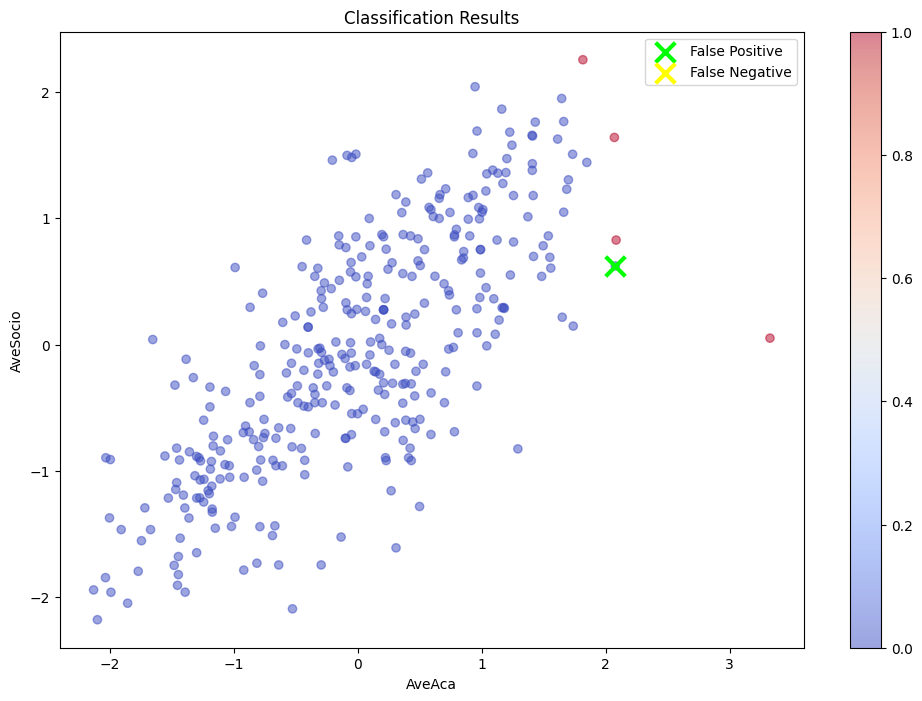

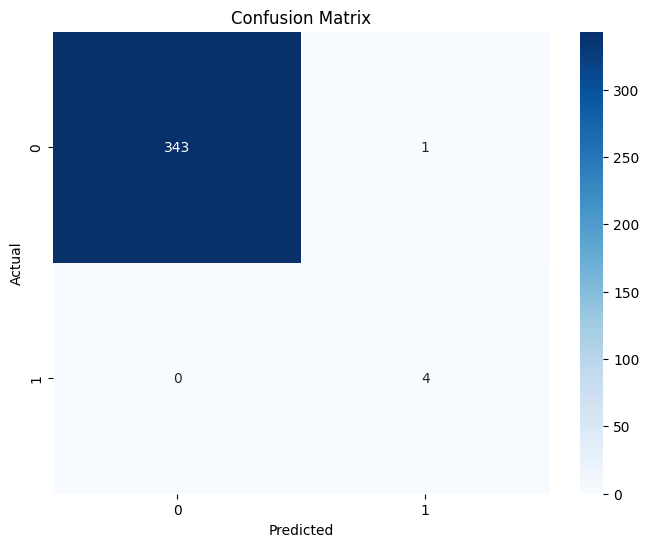

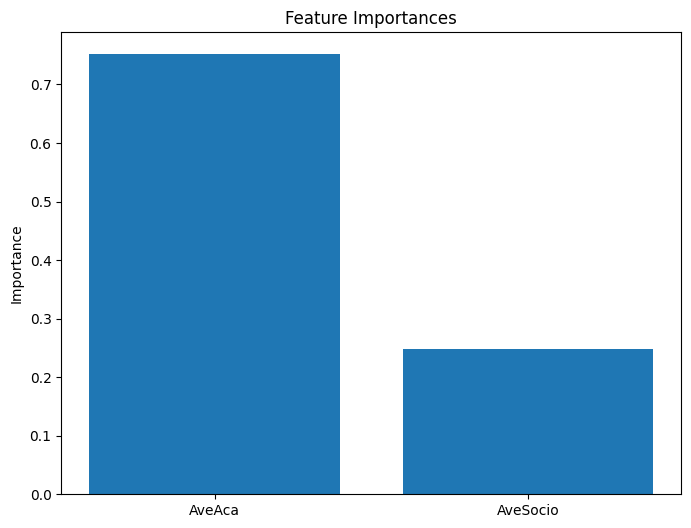

In [ ]:
#Apply random forest to the labeled data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read the generated dataset
df = pd.read_csv('./labeled_data_weighted_gmm.csv')

# Separate features and target
X = df[['AveAca', 'AveSocio']]
y = df['GMM_Label']

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=10)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())

# Train the model on the entire training set
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print feature importances
feature_importance = rf_classifier.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"Importance of {feature}: {importance}")

# Create a scatter plot with different colors for TP, TN, FP, FN
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test['AveAca'], X_test['AveSocio'], c=y_test, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter)

# Plot misclassified points
fp = ((y_pred == 1) & (y_test == 0))
fn = ((y_pred == 0) & (y_test == 1))
plt.scatter(X_test.loc[fp, 'AveAca'], X_test.loc[fp, 'AveSocio'], color='lime', marker='x', s=200, linewidth=3, label='False Positive')
plt.scatter(X_test.loc[fn, 'AveAca'], X_test.loc[fn, 'AveSocio'], color='yellow', marker='x', s=200, linewidth=3, label='False Negative')

plt.xlabel('AveAca')
plt.ylabel('AveSocio')
plt.title('Classification Results')
plt.legend()
plt.show()

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Create a bar plot for feature importances
plt.figure(figsize=(8, 6))
feature_importance = rf_classifier.feature_importances_
feature_names = X.columns
y_pos = np.arange(len(feature_names))
plt.bar(y_pos, feature_importance)
plt.xticks(y_pos, feature_names)
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Cross-validation scores: [0.99137931 1.         1.         0.98275862 0.99137931 0.98275862
 1.         1.         0.99130435 1.        ]
Mean CV score: 0.9939580209895054
Standard deviation of CV scores: 0.006735890174320352

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      0.75      0.86         4

    accuracy                           1.00       348
   macro avg       1.00      0.88      0.93       348
weighted avg       1.00      1.00      1.00       348



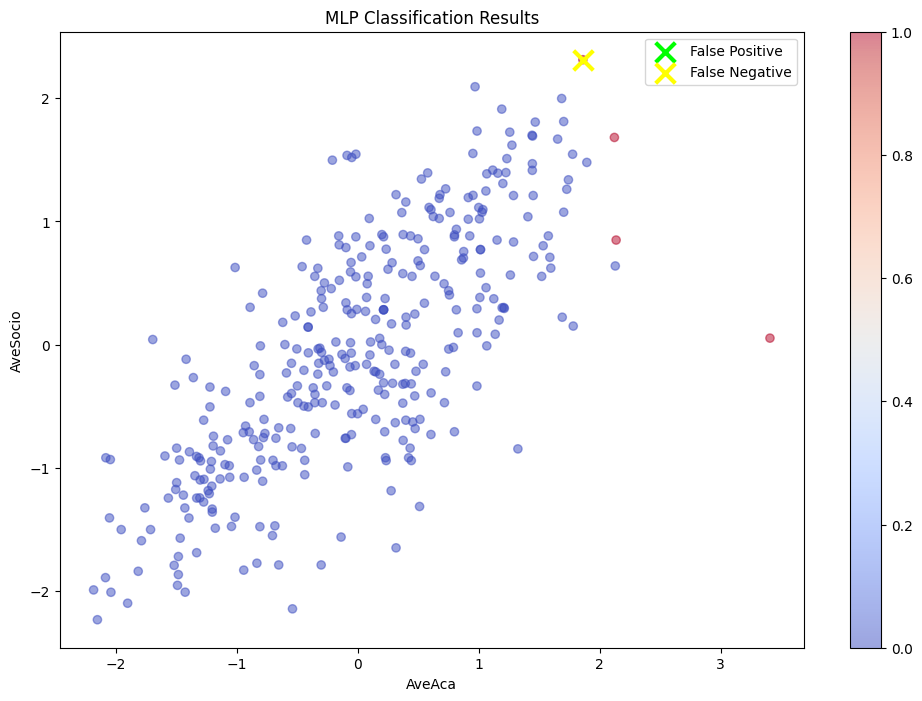

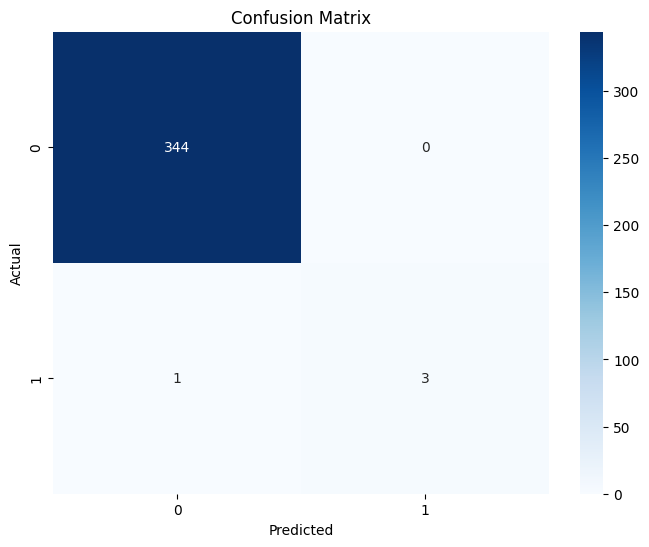

In [ ]:
#Apply MLP - Multi Layer Perceptron to the labeled data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Read the generated dataset
df = pd.read_csv('./labeled_data_weighted_gmm.csv')

# Separate features and target
X = df[['AveAca', 'AveSocio']].values
y = df['GMM_Label'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(mlp, X_scaled, y, cv=10)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the final model
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create a scatter plot with different colors for TP, TN, FP, FN
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter)

# Plot misclassified points
fp = ((y_pred == 1) & (y_test == 0))
fn = ((y_pred == 0) & (y_test == 1))
plt.scatter(X_test[fp, 0], X_test[fp, 1], color='lime', marker='x', s=200, linewidth=3, label='False Positive')
plt.scatter(X_test[fn, 0], X_test[fn, 1], color='yellow', marker='x', s=200, linewidth=3, label='False Negative')

plt.xlabel('AveAca')
plt.ylabel('AveSocio')
plt.title('MLP Classification Results')
plt.legend()
plt.show()

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1140
           1       1.00      0.76      0.87        17

    accuracy                           1.00      1157
   macro avg       1.00      0.88      0.93      1157
weighted avg       1.00      1.00      1.00      1157



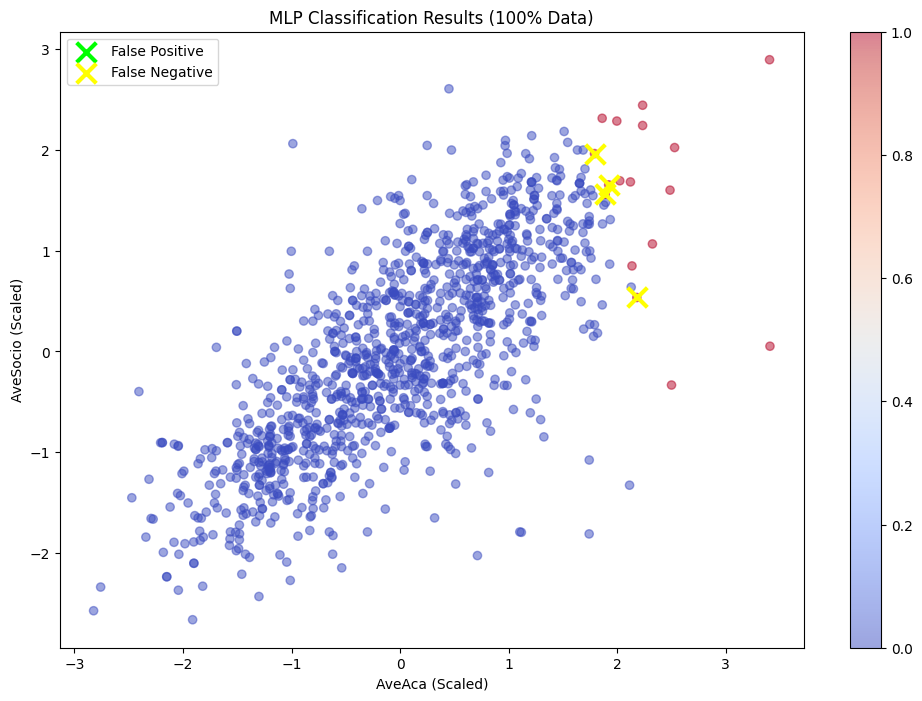

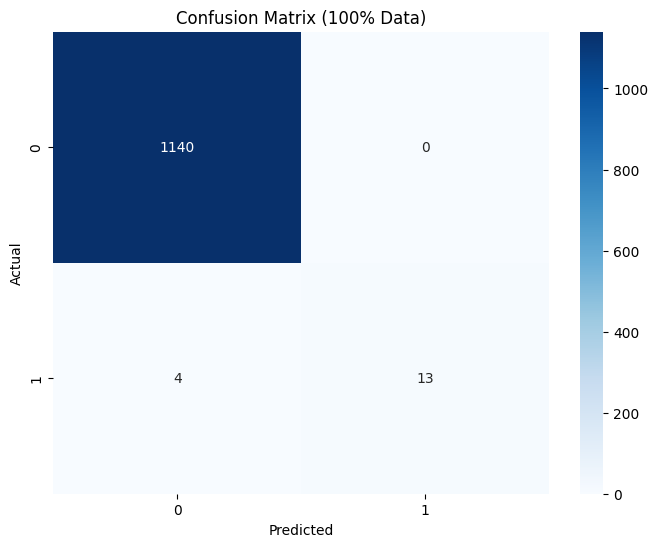


Misclassified instances:
Instance 1: AveAca = 2.13, AveSocio = 0.52
   True label: 1, Predicted label: 0

Instance 2: AveAca = 1.87, AveSocio = 1.61
   True label: 1, Predicted label: 0

Instance 3: AveAca = 1.84, AveSocio = 1.52
   True label: 1, Predicted label: 0

Instance 4: AveAca = 1.75, AveSocio = 1.92
   True label: 1, Predicted label: 0


Total instances: 1157
Total misclassifications: 4
Accuracy: 0.9965


In [ ]:
# with 100% data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Read the generated dataset
df = pd.read_csv('./labeled_data_weighted_gmm.csv')

# Separate features and target
X = df[['AveAca', 'AveSocio']].values
y = df['GMM_Label'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and train the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

# Train the model on the entire dataset
mlp.fit(X_scaled, y)

# Make predictions on the entire dataset
y_pred = mlp.predict(X_scaled)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Create a scatter plot with different colors for TP, TN, FP, FN
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.colorbar(scatter)

# Plot misclassified points
fp = ((y_pred == 1) & (y == 0))
fn = ((y_pred == 0) & (y == 1))
plt.scatter(X_scaled[fp, 0], X_scaled[fp, 1], color='lime', marker='x', s=200, linewidth=3, label='False Positive')
plt.scatter(X_scaled[fn, 0], X_scaled[fn, 1], color='yellow', marker='x', s=200, linewidth=3, label='False Negative')

plt.xlabel('AveAca (Scaled)')
plt.ylabel('AveSocio (Scaled)')
plt.title('MLP Classification Results (100% Data)')
plt.legend()
plt.show()

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (100% Data)')
plt.show()

# Calculate and print misclassification details
misclassified = X[y != y_pred]
misclassified_labels = y[y != y_pred]
misclassified_predictions = y_pred[y != y_pred]

print("\nMisclassified instances:")
for i, (instance, true_label, pred_label) in enumerate(zip(misclassified, misclassified_labels, misclassified_predictions)):
    print(f"Instance {i+1}: AveAca = {instance[0]:.2f}, AveSocio = {instance[1]:.2f}")
    print(f"   True label: {true_label}, Predicted label: {pred_label}")
    print()

# Print total number of instances and misclassifications
total_instances = len(y)
total_misclassified = np.sum(y != y_pred)
print(f"\nTotal instances: {total_instances}")
print(f"Total misclassifications: {total_misclassified}")
print(f"Accuracy: {(total_instances - total_misclassified) / total_instances:.4f}")

No kernel connected

No kernel connected

No kernel connected

No kernel connected